In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import tensorflow as tf
!pip install keras-tuner
from tensorflow.keras import Sequential
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 10.6 MB/s eta 0:00:00


In [3]:
from sklearn.metrics import confusion_matrix, classification_report


In [4]:
from kerastuner.tuners import RandomSearch

/tmp/ipython-input-4-2610907151.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [5]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Training data shape: (60000, 28, 28)
Test data shape: (10000, 28, 28)


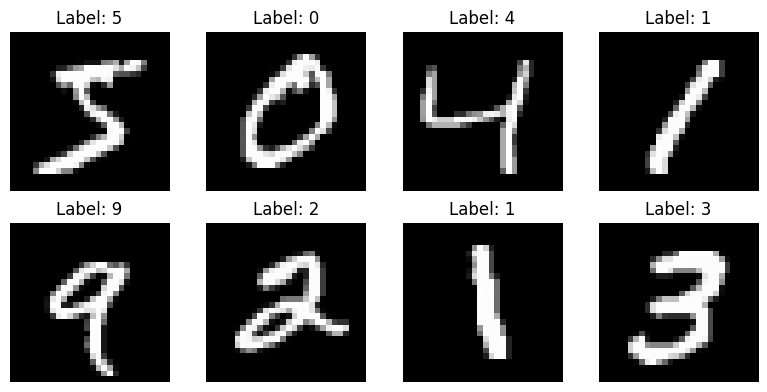

In [6]:
plt.figure(figsize=(8,4))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(X_train[i], cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.tight_layout()

In [7]:
#normalising
X_train = X_train / 255.0
X_test = X_test / 255.0


In [8]:
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)


In [9]:
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)


In [10]:
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)
datagen.fit(X_train)


In [11]:
def build_model(hp):
    model = Sequential()
    model.add(Conv2D(
        filters=hp.Int('conv1_filters', min_value=32, max_value=128, step=32),
        kernel_size=(3,3),
        activation='relu',
        input_shape=(28,28,1)
    ))
    model.add(MaxPooling2D((2,2)))
    model.add(Flatten())
    model.add(Dense(
        units=hp.Int('dense_units', min_value=64, max_value=256, step=64),
        activation='relu'
    ))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [12]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=3,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='mnist_hp_tuning'
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
tuner.search(X_train, y_train_cat, epochs=5, validation_data=(X_test, y_test_cat))


Trial 3 Complete [00h 00m 36s]
val_accuracy: 0.9846000075340271

Best val_accuracy So Far: 0.9878000020980835
Total elapsed time: 00h 02m 30s


In [14]:
best_hp = tuner.get_best_hyperparameters(1)[0]
print("Best conv filters:", best_hp.get('conv1_filters'))
print("Best dense units:", best_hp.get('dense_units'))


Best conv filters: 96
Best dense units: 128


In [15]:
model = Sequential()

In [16]:
model.add(Conv2D(best_hp.get('conv1_filters'), (3,3), activation='relu', input_shape=(28,28,1)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))


In [18]:
model.add(Flatten())
model.add(Dense(best_hp.get('dense_units'), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))


In [19]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 26, 26, 96)     │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 26, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 13, 13, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 11, 11, 64)     │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 11, 11, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 263,690 (1.01 MB)

 Trainable params: 263,114 (1.00 MB)

 Non-trainable params: 576 (2.25 KB)

In [20]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('final_mnist_model.h5', save_best_only=True)


In [21]:
history = model.fit(
    datagen.flow(X_train, y_train_cat, batch_size=64),
    epochs=30,
    validation_data=(X_test, y_test_cat),
    callbacks=[early_stop, checkpoint]
)


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7749 - loss: 0.7392

938/938 ━━━━━━━━━━━━━━━━━━━━ 35s 30ms/step - accuracy: 0.7750 - loss: 0.7388 - val_accuracy: 0.9743 - val_loss: 0.0824
Epoch 2/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9461 - loss: 0.1758

938/938 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.9461 - loss: 0.1758 - val_accuracy: 0.9899 - val_loss: 0.0314
Epoch 3/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step - accuracy: 0.9609 - loss: 0.1271 - val_accuracy: 0.9863 - val_loss: 0.0423
Epoch 4/30
936/938 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9667 - loss: 0.1080

938/938 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.9667 - loss: 0.1080 - val_accuracy: 0.9918 - val_loss: 0.0282
Epoch 5/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.9691 - loss: 0.0981 - val_accuracy: 0.9886 - val_loss: 0.0390
Epoch 6/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.9724 - loss: 0.0929 - val_accuracy: 0.9902 - val_loss: 0.0340
Epoch 7/30
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9731 - loss: 0.0857

938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.9731 - loss: 0.0857 - val_accuracy: 0.9928 - val_loss: 0.0222
Epoch 8/30
936/938 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9757 - loss: 0.0791

938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.9757 - loss: 0.0791 - val_accuracy: 0.9941 - val_loss: 0.0204
Epoch 9/30
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9765 - loss: 0.0808

938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.9765 - loss: 0.0808 - val_accuracy: 0.9941 - val_loss: 0.0191
Epoch 10/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.9776 - loss: 0.0739 - val_accuracy: 0.9935 - val_loss: 0.0193
Epoch 11/30
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9797 - loss: 0.0684

938/938 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.9797 - loss: 0.0684 - val_accuracy: 0.9941 - val_loss: 0.0179
Epoch 12/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.9796 - loss: 0.0658 - val_accuracy: 0.9897 - val_loss: 0.0326
Epoch 13/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.9803 - loss: 0.0634 - val_accuracy: 0.9939 - val_loss: 0.0190
Epoch 14/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.9800 - loss: 0.0686 - val_accuracy: 0.9933 - val_loss: 0.0195
Epoch 15/30
936/938 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9811 - loss: 0.0635

938/938 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.9811 - loss: 0.0635 - val_accuracy: 0.9945 - val_loss: 0.0155
Epoch 16/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.9815 - loss: 0.0611 - val_accuracy: 0.9950 - val_loss: 0.0173
Epoch 17/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.9827 - loss: 0.0582 - val_accuracy: 0.9932 - val_loss: 0.0235
Epoch 18/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.9836 - loss: 0.0524 - val_accuracy: 0.9945 - val_loss: 0.0167
Epoch 19/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 42s 23ms/step - accuracy: 0.9832 - loss: 0.0552 - val_accuracy: 0.9940 - val_loss: 0.0194
Epoch 20/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 22s 24ms/step - accuracy: 0.9845 - loss: 0.0528 - val_accuracy: 0.9945 - val_loss: 0.0168


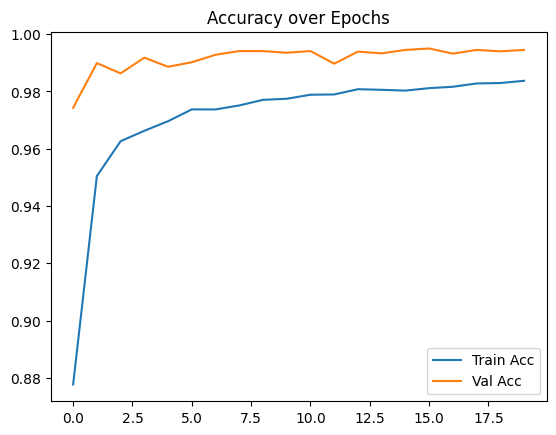

In [22]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy over Epochs')
plt.show()


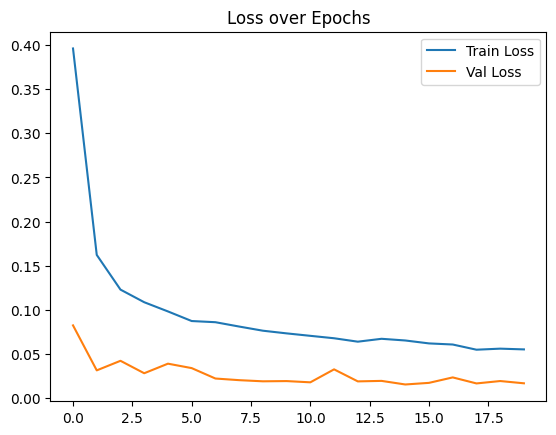

In [23]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.show()


In [24]:
y_pred = np.argmax(model.predict(X_test), axis=1)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


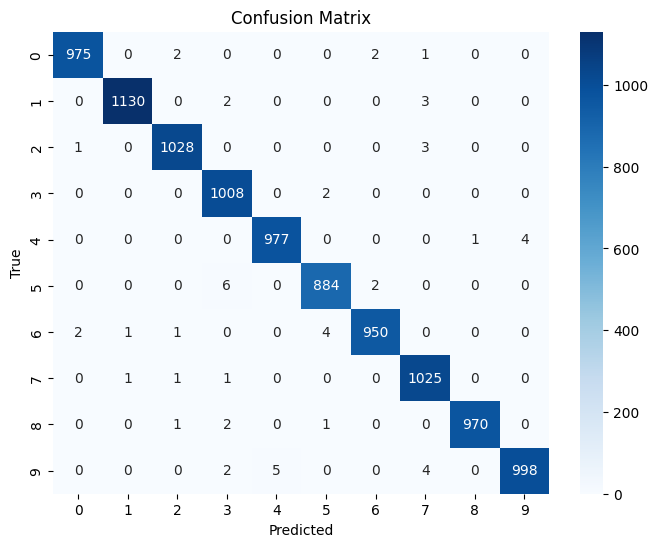

In [25]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [26]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       980
           1       1.00      1.00      1.00      1135
           2       1.00      1.00      1.00      1032
           3       0.99      1.00      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      1.00      0.99      1028
           8       1.00      1.00      1.00       974
           9       1.00      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



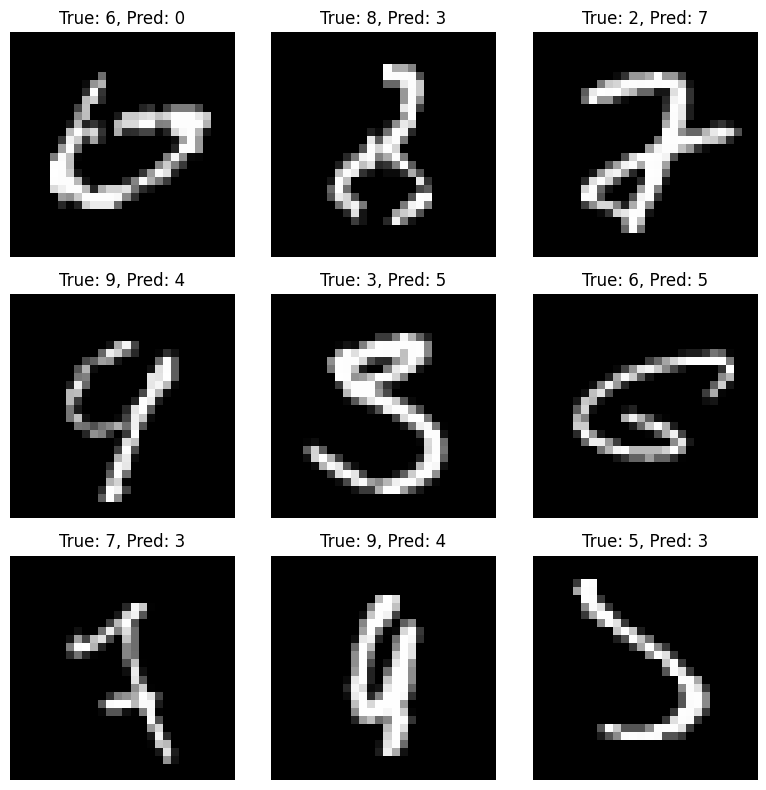

In [27]:
misclassified_idx = np.where(y_pred != y_test)[0]
plt.figure(figsize=(8,8))
for i, idx in enumerate(misclassified_idx[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[idx].reshape(28,28), cmap='gray')
    plt.title(f"True: {y_test[idx]}, Pred: {y_pred[idx]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [28]:
model.save('final_mnist_model.h5')

In [29]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('final_mnist_model.tflite', 'wb') as f:
    f.write(tflite_model)


Saved artifact at '/tmp/tmpswn51jcd'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='keras_tensor_16')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  137518527321424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137518524846864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137518524848208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137518519825232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137518524845904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137518524846672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137518524847440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137518524846480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137518517580240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137518517581200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137518517579

In [30]:
loaded_model = tf.keras.models.load_model('final_mnist_model.h5')


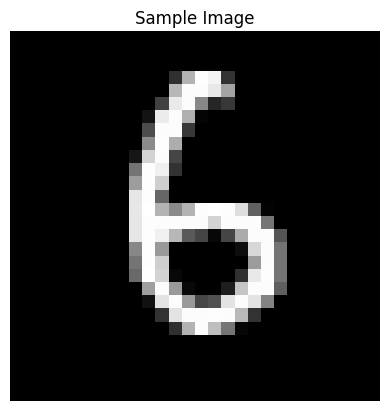

In [58]:
test_img = X_test[21]
plt.imshow(test_img.reshape(28,28), cmap='gray')
plt.title("Sample Image")
plt.axis('off')
plt.show()


In [59]:
test_img = test_img.reshape(1,28,28,1)
predicted_label = np.argmax(loaded_model.predict(test_img))
print(f"Predicted Digit: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Predicted Digit: 6


In [33]:
def fgsm_attack(image, label, model, epsilon=0.1):
    image = tf.convert_to_tensor(image)
    label = tf.convert_to_tensor(label)
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.categorical_crossentropy(label, prediction)
    gradient = tape.gradient(loss, image)
    signed_grad = tf.sign(gradient)
    adv_image = image + epsilon * signed_grad
    adv_image = tf.clip_by_value(adv_image, 0, 1)
    return adv_image


In [34]:
X_test_adv = []
for i in range(len(X_test)):
    img = X_test[i].reshape(1,28,28,1)
    label = y_test_cat[i].reshape(1,-1)
    adv_img = fgsm_attack(img, label, model, epsilon=0.1)
    X_test_adv.append(adv_img.numpy().reshape(28,28,1))
X_test_adv = np.array(X_test_adv)


In [35]:
loss_adv, acc_adv = model.evaluate(X_test_adv, y_test_cat, verbose=1)
print(f"Accuracy on adversarial examples BEFORE defense: {acc_adv:.4f}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5357 - loss: 1.8914
Accuracy on adversarial examples BEFORE defense: 0.5896


In [36]:
sample_indices = np.random.choice(len(X_train), size=5000, replace=False)

In [37]:
X_train_adv = []
for i in sample_indices:
    img = X_train[i].reshape(1,28,28,1)
    label = y_train_cat[i].reshape(1,-1)
    adv_img = fgsm_attack(img, label, model, epsilon=0.1)
    X_train_adv.append(adv_img.numpy().reshape(28,28,1))


In [38]:
X_train_adv = np.array(X_train_adv)
y_train_adv_cat = y_train_cat[sample_indices]


In [39]:
X_train_combined = np.concatenate((X_train, X_train_adv), axis=0)
y_train_combined = np.concatenate((y_train_cat, y_train_adv_cat), axis=0)


In [40]:
print("Combined training set shape:", X_train_combined.shape)

Combined training set shape: (65000, 28, 28, 1)


In [41]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('final_mnist_adv_trained.h5', save_best_only=True)


In [42]:
history_adv = model.fit(
    datagen.flow(X_train_combined, y_train_combined, batch_size=64),
    epochs=20,
    validation_data=(X_test, y_test_cat),
    callbacks=[early_stop, checkpoint]
)


Epoch 1/20
   4/1016 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.9290 - loss: 0.3004

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1015/1016 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9745 - loss: 0.0880

1016/1016 ━━━━━━━━━━━━━━━━━━━━ 29s 28ms/step - accuracy: 0.9745 - loss: 0.0880 - val_accuracy: 0.9916 - val_loss: 0.0234
Epoch 2/20
1014/1016 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9799 - loss: 0.0670

1016/1016 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - accuracy: 0.9799 - loss: 0.0670 - val_accuracy: 0.9940 - val_loss: 0.0183
Epoch 3/20
1016/1016 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - accuracy: 0.9791 - loss: 0.0701 - val_accuracy: 0.9915 - val_loss: 0.0252
Epoch 4/20
1015/1016 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9811 - loss: 0.0636

1016/1016 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - accuracy: 0.9811 - loss: 0.0636 - val_accuracy: 0.9942 - val_loss: 0.0169
Epoch 5/20
1015/1016 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9807 - loss: 0.0640

1016/1016 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.9807 - loss: 0.0640 - val_accuracy: 0.9943 - val_loss: 0.0162
Epoch 6/20
1016/1016 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.9828 - loss: 0.0579 - val_accuracy: 0.9942 - val_loss: 0.0167
Epoch 7/20
1016/1016 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - accuracy: 0.9837 - loss: 0.0547 - val_accuracy: 0.9939 - val_loss: 0.0174
Epoch 8/20
1015/1016 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9829 - loss: 0.0574

1016/1016 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - accuracy: 0.9829 - loss: 0.0574 - val_accuracy: 0.9942 - val_loss: 0.0161
Epoch 9/20
1016/1016 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - accuracy: 0.9829 - loss: 0.0555 - val_accuracy: 0.9947 - val_loss: 0.0171
Epoch 10/20
1014/1016 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9838 - loss: 0.0543

1016/1016 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - accuracy: 0.9838 - loss: 0.0543 - val_accuracy: 0.9949 - val_loss: 0.0161
Epoch 11/20
1016/1016 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9838 - loss: 0.0526

1016/1016 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - accuracy: 0.9838 - loss: 0.0526 - val_accuracy: 0.9954 - val_loss: 0.0141
Epoch 12/20
1016/1016 ━━━━━━━━━━━━━━━━━━━━ 41s 25ms/step - accuracy: 0.9837 - loss: 0.0546 - val_accuracy: 0.9941 - val_loss: 0.0190
Epoch 13/20
1016/1016 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - accuracy: 0.9839 - loss: 0.0533 - val_accuracy: 0.9911 - val_loss: 0.0251
Epoch 14/20
1016/1016 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9841 - loss: 0.0495

1016/1016 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - accuracy: 0.9841 - loss: 0.0495 - val_accuracy: 0.9960 - val_loss: 0.0129
Epoch 15/20
1016/1016 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9837 - loss: 0.0526

1016/1016 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - accuracy: 0.9837 - loss: 0.0526 - val_accuracy: 0.9957 - val_loss: 0.0125
Epoch 16/20
1016/1016 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - accuracy: 0.9855 - loss: 0.0470 - val_accuracy: 0.9953 - val_loss: 0.0136
Epoch 17/20
1016/1016 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.9851 - loss: 0.0486 - val_accuracy: 0.9949 - val_loss: 0.0151
Epoch 18/20
1016/1016 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.9861 - loss: 0.0450 - val_accuracy: 0.9938 - val_loss: 0.0174
Epoch 19/20
1016/1016 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.9850 - loss: 0.0515 - val_accuracy: 0.9953 - val_loss: 0.0129
Epoch 20/20
1016/1016 ━━━━━━━━━━━━━━━━━━━━ 39s 24ms/step - accuracy: 0.9852 - loss: 0.0494 - val_accuracy: 0.9946 - val_loss: 0.0165


In [43]:
loss_adv_def, acc_adv_def = model.evaluate(X_test_adv, y_test_cat, verbose=1)
print(f"Accuracy on adversarial examples AFTER defense: {acc_adv_def:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9513 - loss: 0.1442
Accuracy on adversarial examples AFTER defense: 0.9640


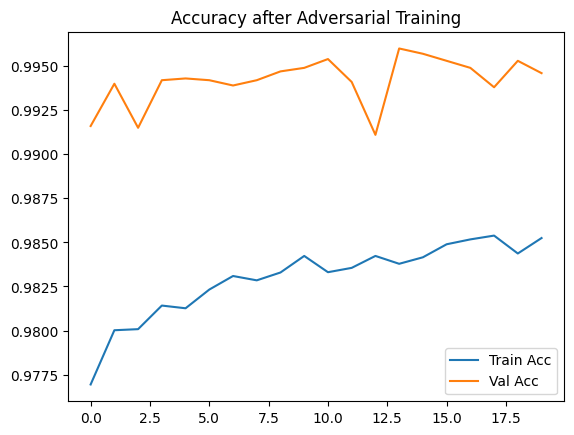

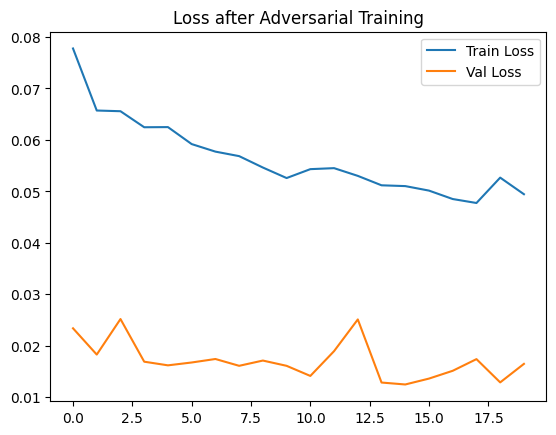

In [44]:
plt.plot(history_adv.history['accuracy'], label='Train Acc')
plt.plot(history_adv.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy after Adversarial Training')
plt.show()

plt.plot(history_adv.history['loss'], label='Train Loss')
plt.plot(history_adv.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss after Adversarial Training')
plt.show()

In [45]:
loss_clean, acc_clean = model.evaluate(X_test, y_test_cat, verbose=1)
print(f"Accuracy on clean test data AFTER adversarial training: {acc_clean:.4f}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9942 - loss: 0.0151
Accuracy on clean test data AFTER adversarial training: 0.9957


In [46]:
sample_indices = np.random.choice(len(X_test), size=1000, replace=False)


In [47]:
X_test_adv = []
for i in sample_indices:
    img = X_test[i].reshape(1,28,28,1)
    label = y_test_cat[i].reshape(1,-1)
    adv_img = fgsm_attack(img, label, model, epsilon=0.1)
    X_test_adv.append(adv_img.numpy().reshape(28,28,1))
X_test_adv = np.array(X_test_adv)
y_test_adv_cat = y_test_cat[sample_indices]


In [48]:
loss_adv_def, acc_adv_def = model.evaluate(X_test_adv, y_test_adv_cat, verbose=1)
print(f"Accuracy on adversarial examples AFTER defense: {acc_adv_def:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.7019 - loss: 0.9204
Accuracy on adversarial examples AFTER defense: 0.7090


In [49]:
!ls -lh


total 7.2M
-rw-r--r-- 1 root root 3.1M Jul  3 13:42 final_mnist_adv_trained.h5
-rw-r--r-- 1 root root 3.1M Jul  3 13:27 final_mnist_model.h5
-rw-r--r-- 1 root root 1.1M Jul  3 13:27 final_mnist_model.tflite
drwxr-xr-x 1 root root 4.0K Jul  1 21:04 sample_data
drwxr-xr-x 3 root root 4.0K Jul  3 13:16 tuner_dir


In [50]:
from google.colab import files
files.download('final_mnist_model.h5')
files.download('final_mnist_model.tflite')
files.download('final_mnist_adv_trained.h5')

files.download('tuner_dir')
files.download('sample_data')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [51]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_adv_model = converter.convert()

with open('final_mnist_adv_trained.tflite', 'wb') as f:
    f.write(tflite_adv_model)

Saved artifact at '/tmp/tmpup7906qh'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='keras_tensor_16')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  137518527321424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137518524846864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137518524848208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137518519825232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137518524845904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137518524846672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137518524847440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137518524846480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137518517580240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137518517581200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137518517579

In [52]:
files.download('final_mnist_adv_trained.tflite')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>